<a href="https://colab.research.google.com/github/tuesmonsoleil/Dysgraphia-Classification/blob/main/FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

from torchvision.models import resnet50, ResNet50_Weights

from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
from PIL import Image

In [2]:
# Define data directory
data_dir = "train"
from google.colab import drive
drive.mount('/content/drive')
Dataset = os.chdir('/content/drive/My Drive/Dataset/dataSciRep_public') #切換該目錄
os.listdir() #確認目錄內容

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['test',
 'train',
 'dataset',
 'model_fold5.pth',
 'model_fold1.pth',
 'model_fold2.pth',
 'model_fold3.pth',
 'model_fold4.pth']

In [3]:
!pip install protobuf==3.20.3
!pip install --upgrade tensorflow-metadata
!pip install -q flwr[simulation] torch torchvision scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flwr 1.8.0 requires protobuf<5.0.0,>=4.25.2, but you have protobuf 3.20.3 which is incompatible.


ERROR: Operation cancelled by user


In [2]:
!pip install -q flwr[simulation] torch torchvision scipy

In [3]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

import flwr as fl

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.2.1+cu121 and Flower 1.8.0


In [4]:
NUM_CLIENTS = 2


def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 20  # 20 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=40, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=40))
    testloader = DataLoader(testset, batch_size=40)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


100%|██████████| 170498071/170498071 [00:15<00:00, 10900428.73it/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


In [5]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [6]:
class FlowerNumPyClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def numpyclient_fn(cid) -> FlowerNumPyClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerNumPyClient(cid, net, trainloader, valloader)

In [7]:
# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

fl.simulation.start_simulation(
    client_fn=numpyclient_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=5),
    client_resources=client_resources,
)

import matplotlib.pyplot as plt

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()

    # Initialize lists to store training loss and accuracy
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()

        # Calculate and store training accuracy for this epoch
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

    # Plot training loss and accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
INFO:flwr:Starting Flower simulation, config: num_rounds=5, no round_timeout
2024-04-08 15:55:34,813	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'object_store_memory': 3918962688.0, 'memory': 7837925376.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'object_store_memory': 3918962688.0, 'memory': 7837925376.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resour

(ClientAppActor pid=9695) [Client 0] get_parameters
(ClientAppActor pid=9695) [Client 1] fit, config: {}


(ClientAppActor pid=9695) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=9694) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9694) [Client 0] fit, config: {}
(ClientAppActor pid=9695) Epoch 1: train loss 0.044374361634254456, accuracy 0.34454736842105266


INFO :      aggregate_fit: received 2 results and 0 failures
INFO:flwr:aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 2)
(ClientAppActor pid=9694) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9694) [Client 0] evaluate, config: {}
(ClientAppActor pid=9694) Epoch 1: train loss 0.04453033581376076, accuracy 0.33818947368421054


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 2]
INFO:flwr:[ROUND 2]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
INFO:flwr:configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=9695) [Client 1] fit, config: {}
(ClientAppActor pid=9695) Epoch 1: train loss 0.03795081377029419, accuracy 0.4415578947368421
(ClientAppActor pid=9695) [Client 1] evaluate, config: {}
(ClientAppActor pid=9694) [Client 0] fit, config: {}


INFO :      aggregate_fit: received 2 results and 0 failures
INFO:flwr:aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 2)
(ClientAppActor pid=9694) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


(ClientAppActor pid=9694) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 3]
INFO:flwr:[ROUND 3]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
INFO:flwr:configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=9695) [Client 0] fit, config: {}
(ClientAppActor pid=9694) Epoch 1: train loss 0.03816397860646248, accuracy 0.4399578947368421
(ClientAppActor pid=9695) Epoch 1: train loss 0.03493233770132065, accuracy 0.4965052631578947
(ClientAppActor pid=9695) [Client 0] evaluate, config: {}
(ClientAppActor pid=9694) [Client 1] fit, config: {}


INFO :      aggregate_fit: received 2 results and 0 failures
INFO:flwr:aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 2)
(ClientAppActor pid=9694) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=9694) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 4]
INFO:flwr:[ROUND 4]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
INFO:flwr:configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=9695) [Client 0] fit, config: {}
(ClientAppActor pid=9694) Epoch 1: train loss 0.03458614647388458, accuracy 0.5020631578947369


(ClientAppActor pid=9694) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=9695) [Client 0] evaluate, config: {}
(ClientAppActor pid=9695) Epoch 1: train loss 0.032594889402389526, accuracy 0.5288
(ClientAppActor pid=9694) [Client 1] fit, config: {}


INFO :      aggregate_fit: received 2 results and 0 failures
INFO:flwr:aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 2)
(ClientAppActor pid=9694) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9694) [Client 0] evaluate, config: {}
(ClientAppActor pid=9694) Epoch 1: train loss 0.03224384784698486, accuracy 0.5338105263157895


(ClientAppActor pid=9695) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 5]
INFO:flwr:[ROUND 5]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
INFO:flwr:configure_fit: strategy sampled 2 clients (out of 2)
(ClientAppActor pid=9695) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9695) [Client 1] fit, config: {}
(ClientAppActor pid=9695) Epoch 1: train loss 0.03064645268023014, accuracy 0.5604210526315789
(ClientAppActor pid=9695) [Client 1] evaluate, config: {}
(ClientAppActor pid=9694) [Client 0] fit, config: {}


INFO :      aggregate_fit: received 2 results and 0 failures
INFO:flwr:aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 2)
(ClientAppActor pid=9694) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=9694) [Client 0] evaluate, config: {}
(ClientAppActor pid=9694) Epoch 1: train loss 0.03092934750020504, accuracy 0.5549894736842105


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [SUMMARY]
INFO:flwr:[SUMMARY]
INFO :      Run finished 5 rounds in 164.03s
INFO:flwr:Run finished 5 rounds in 164.03s
INFO :      History (loss, distributed):
INFO:flwr:History (loss, distributed):
INFO :      	('\tround 1: 0.042935062360763554\n'
INFO:flwr:	('\tround 1: 0.042935062360763554\n'
INFO :      	 '\tround 2: 0.03598315672874451\n'
INFO:flwr:	 '\tround 2: 0.03598315672874451\n'
INFO :      	 '\tround 3: 0.033756054162979124\n'
INFO:flwr:	 '\tround 3: 0.033756054162979124\n'
INFO :      	 '\tround 4: 0.03133438820838928\n'
INFO:flwr:	 '\tround 4: 0.03133438820838928\n'
INFO :      	 '\tround 5: 0.030346675658226012\n')
INFO:flwr:	 '\tround 5: 0.030346675658226012\n')
INFO :      
INFO:flwr:


INFO :      Starting Flower simulation, config: num_rounds=3, no round_timeout
INFO:flwr:Starting Flower simulation, config: num_rounds=3, no round_timeout
2024-04-08 16:11:53,447	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 7834723124.0, 'object_store_memory': 3917361561.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 7834723124.0, 'object_store_memory': 3917361561.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resour

(ClientAppActor pid=14330) [Client 0] get_parameters
(ClientAppActor pid=14330) [Client 1] fit, config: {}
(ClientAppActor pid=14329) [Client 0] fit, config: {}
(ClientAppActor pid=14330) Epoch 1: train loss 0.04366038367152214, accuracy 0.34993684210526316
(ClientAppActor pid=14329) Epoch 1: train loss 0.04440964385867119, accuracy 0.346821052631579
(ClientAppActor pid=14330) Epoch 2: train loss 0.03614255413413048, accuracy 0.47372631578947366
(ClientAppActor pid=14329) Epoch 2: train loss 0.036764346063137054, accuracy 0.46442105263157896
(ClientAppActor pid=14330) Epoch 3: train loss 0.03329597786068916, accuracy 0.5165052631578947
(ClientAppActor pid=14329) Epoch 3: train loss 0.033584777265787125, accuracy 0.5157473684210526
(ClientAppActor pid=14330) Epoch 4: train loss 0.031147368252277374, accuracy 0.5506947368421052
(ClientAppActor pid=14329) Epoch 4: train loss 0.031007854267954826, accuracy 0.5557052631578947
(ClientAppActor pid=14330) Epoch 5: train loss 0.0296728573739528

(ClientAppActor pid=14330) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=14330) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=14330) see the appropriate new directories, set the environment variable
(ClientAppActor pid=14330) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=14330) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=14330)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
(pid=14329) 2024-04-08 16:11:59.175715: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=14329) 2024-04-08 16:11:59.175771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT 

(ClientAppActor pid=14329) Epoch 5: train loss 0.029206113889813423, accuracy 0.5829894736842105
(ClientAppActor pid=14329) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 2]
INFO:flwr:[ROUND 2]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
INFO:flwr:configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=14330) [Client 0] fit, config: {}
(ClientAppActor pid=14330) Epoch 1: train loss 0.044717926532030106, accuracy 0.34433684210526316
(ClientAppActor pid=14330) [Client 0] evaluate, config: {}
(ClientAppActor pid=14329) [Client 1] fit, config: {}
(ClientAppActor pid=14330) Epoch 2: train loss 0.03686114400625229, accuracy 0.4647578947368421 [repeated 2x across cluster]
(ClientAppActor pid=14330) Epoch 3: train loss 0.033519357442855835, accuracy 0.5170526315789473 [repeated 2x across cluster]
(ClientAppActor pid=14330) Epoch 4: train loss 0.031095029786229134, accuracy 0.5558736842105263 [repeated 2x across cluster]


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 73, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 399, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 280, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2524, in get
    raise value.as_instanceof_cause()
ray.excepti

(ClientAppActor pid=14330) Epoch 5: train loss 0.02912336029112339, accuracy 0.5848842105263158 [repeated 2x across cluster]


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 73, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 399, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 280, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2524, in get
    raise value.as_instanceof_cause()
ray.excepti

(ClientAppActor pid=14329) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 3]
INFO:flwr:[ROUND 3]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
INFO:flwr:configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=14330) [Client 1] fit, config: {}
(ClientAppActor pid=14329) Epoch 5: train loss 0.029149146750569344, accuracy 0.5794947368421053
(ClientAppActor pid=14330) Epoch 1: train loss 0.0441487617790699, accuracy 0.3535578947368421
(ClientAppActor pid=14330) [Client 1] evaluate, config: {}
(ClientAppActor pid=14329) [Client 0] fit, config: {}
(ClientAppActor pid=14330) Epoch 2: train loss 0.03652910515666008, accuracy 0.4688842105263158 [repeated 2x across cluster]
(ClientAppActor pid=14330) Epoch 3: train loss 0.03304485231637955, accuracy 0.5213473684210527 [repeated 2x across cluster]
(ClientAppActor pid=14330) Epoch 4: train loss 0.030588839203119278, accuracy 0.5625263157894737 [repeated 2x across cluster]


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 73, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 399, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 280, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2524, in get
    raise value.as_instanceof_cause()
ray.excepti

(ClientAppActor pid=14330) Epoch 5: train loss 0.0287080816924572, accuracy 0.5890526315789474 [repeated 2x across cluster]


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 73, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 399, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 280, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2524, in get
    raise value.as_instanceof_cause()
ray.excepti

(ClientAppActor pid=14329) [Client 0] evaluate, config: {}
(ClientAppActor pid=14329) Epoch 5: train loss 0.029734531417489052, accuracy 0.5757052631578947


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [SUMMARY]
INFO:flwr:[SUMMARY]
INFO :      Run finished 3 rounds in 423.20s
INFO:flwr:Run finished 3 rounds in 423.20s
INFO :      History (loss, distributed):
INFO:flwr:History (loss, distributed):
INFO :      	('\tround 1: 0.05900006608963013\n'
INFO:flwr:	('\tround 1: 0.05900006608963013\n'
INFO :      	 '\tround 2: 0.05900006608963013\n'
INFO:flwr:	 '\tround 2: 0.05900006608963013\n'
INFO :      	 '\tround 3: 0.05900006608963013\n')
INFO:flwr:	 '\tround 3: 0.05900006608963013\n')
INFO :      
INFO:flwr:


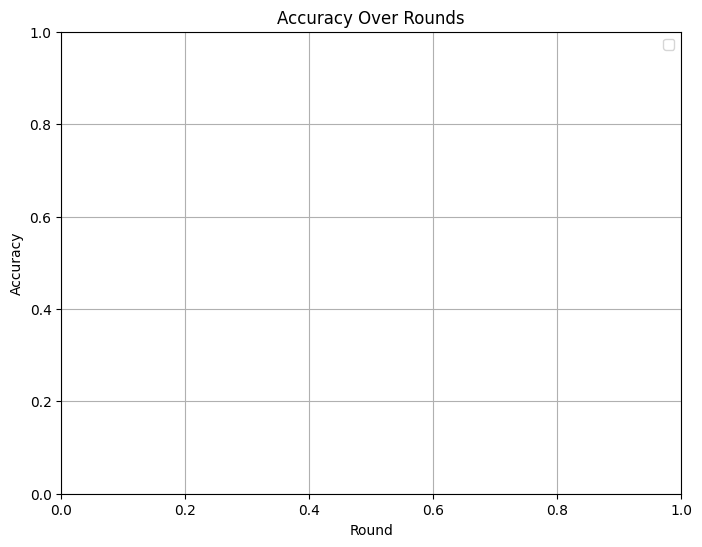

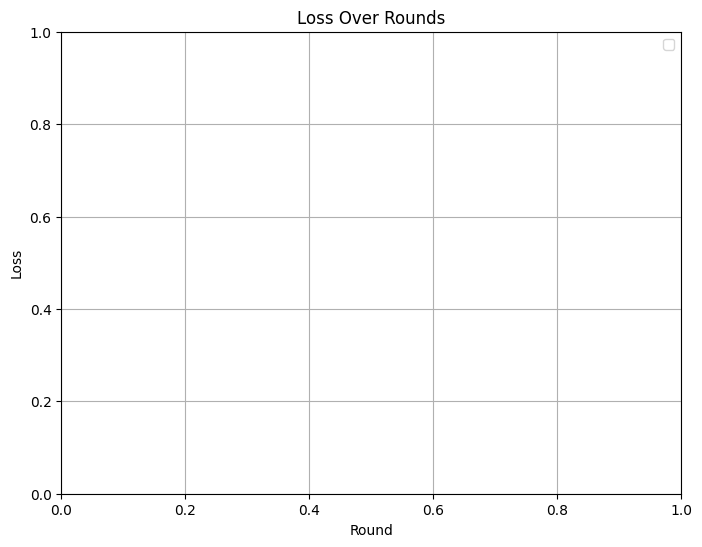

In [15]:
from flwr.common import (
    Code,
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    GetParametersIns,
    GetParametersRes,
    Status,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)

metrics_list = []
class FlowerClient(fl.client.Client):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.metrics_list = []

    def get_parameters(self, ins: GetParametersIns) -> GetParametersRes:
        print(f"[Client {self.cid}] get_parameters")

        # Get parameters as a list of NumPy ndarray's
        ndarrays: List[np.ndarray] = get_parameters(self.net)

        # Serialize ndarray's into a Parameters object
        parameters = ndarrays_to_parameters(ndarrays)

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return GetParametersRes(
            status=status,
            parameters=parameters,
        )

    def fit(self, ins: FitIns) -> FitRes:
        print(f"[Client {self.cid}] fit, config: {ins.config}")

        # Deserialize parameters to NumPy ndarray's
        parameters_original = ins.parameters
        ndarrays_original = parameters_to_ndarrays(parameters_original)

        # Update local model, train, get updated parameters
        set_parameters(self.net, ndarrays_original)
        train(self.net, self.trainloader, epochs=5)
        ndarrays_updated = get_parameters(self.net)

        # Serialize ndarray's into a Parameters object
        parameters_updated = ndarrays_to_parameters(ndarrays_updated)

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=parameters_updated,
            num_examples=len(self.trainloader),
            metrics={},
        )

    def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
        print(f"[Client {self.cid}] evaluate, config: {ins.config}")

        # Deserialize parameters to NumPy ndarray's
        parameters_original = ins.parameters
        ndarrays_original = parameters_to_ndarrays(parameters_original)

        set_parameters(self.net, ndarrays_original)
        loss, accuracy = test(self.net, self.valloader)
        # return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

        self.metrics_list.append({'accuracy': accuracy, 'loss': loss})

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return EvaluateRes(
            status=status,
            loss=float(loss),
            num_examples=len(self.valloader),
            metrics={"accuracy": float(accuracy)},
        )


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader)

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=3),
    client_resources=client_resources,
)

import matplotlib.pyplot as plt

def plot_metrics(metrics_list, metric_name):
    plt.figure(figsize=(8, 6))
    for cid, metrics in enumerate(metrics_list, 1):
        rounds = list(range(1, len(metrics) + 1))
        metric_values = [metric[metric_name] for metric in metrics]
        plt.plot(rounds, metric_values, label=f"Client {cid}")
    plt.xlabel('Round')
    plt.ylabel(metric_name.capitalize())
    plt.title(f'{metric_name.capitalize()} Over Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics(metrics_list, 'accuracy')
plot_metrics(metrics_list, 'loss')

In [16]:
class FlowerClient(fl.client.Client):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.train_losses = []  # 用來儲存訓練損失的列表
        self.train_accuracies = []  # 用來儲存訓練準確率的列表

    # 其他方法保持不變

    def fit(self, ins: FitIns) -> FitRes:
        print(f"[Client {self.cid}] fit, config: {ins.config}")

        # Deserialize parameters to NumPy ndarray's
        parameters_original = ins.parameters
        ndarrays_original = parameters_to_ndarrays(parameters_original)

        # Update local model, train, get updated parameters
        set_parameters(self.net, ndarrays_original)
        train(self.net, self.trainloader, epochs=5, client_id=self.cid)
        ndarrays_updated = get_parameters(self.net)

        # Serialize ndarray's into a Parameters object
        parameters_updated = ndarrays_to_parameters(ndarrays_updated)

        # Plot training loss and accuracy
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        for i, losses in enumerate(self.train_losses):
            plt.plot(range(1, len(losses) + 1), losses, label=f'Epoch {i+1}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Client {self.cid} Training Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        for i, accuracies in enumerate(self.train_accuracies):
            plt.plot(range(1, len(accuracies) + 1), accuracies, label=f'Epoch {i+1}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(f'Client {self.cid} Training Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=parameters_updated,
            num_examples=len(self.trainloader),
            metrics={},
        )

In [17]:
from io import BytesIO
from typing import cast

import numpy as np

from flwr.common.typing import NDArray, NDArrays, Parameters


def ndarrays_to_sparse_parameters(ndarrays: NDArrays) -> Parameters:
    """Convert NumPy ndarrays to parameters object."""
    tensors = [ndarray_to_sparse_bytes(ndarray) for ndarray in ndarrays]
    return Parameters(tensors=tensors, tensor_type="numpy.ndarray")


def sparse_parameters_to_ndarrays(parameters: Parameters) -> NDArrays:
    """Convert parameters object to NumPy ndarrays."""
    return [sparse_bytes_to_ndarray(tensor) for tensor in parameters.tensors]


def ndarray_to_sparse_bytes(ndarray: NDArray) -> bytes:
    """Serialize NumPy ndarray to bytes."""
    bytes_io = BytesIO()

    if len(ndarray.shape) > 1:
        # We convert our ndarray into a sparse matrix
        ndarray = torch.tensor(ndarray).to_sparse_csr()

        # And send it byutilizing the sparse matrix attributes
        # WARNING: NEVER set allow_pickle to true.
        # Reason: loading pickled data can execute arbitrary code
        # Source: https://numpy.org/doc/stable/reference/generated/numpy.save.html
        np.savez(
            bytes_io,  # type: ignore
            crow_indices=ndarray.crow_indices(),
            col_indices=ndarray.col_indices(),
            values=ndarray.values(),
            allow_pickle=False,
        )
    else:
        # WARNING: NEVER set allow_pickle to true.
        # Reason: loading pickled data can execute arbitrary code
        # Source: https://numpy.org/doc/stable/reference/generated/numpy.save.html
        np.save(bytes_io, ndarray, allow_pickle=False)
    return bytes_io.getvalue()


def sparse_bytes_to_ndarray(tensor: bytes) -> NDArray:
    """Deserialize NumPy ndarray from bytes."""
    bytes_io = BytesIO(tensor)
    # WARNING: NEVER set allow_pickle to true.
    # Reason: loading pickled data can execute arbitrary code
    # Source: https://numpy.org/doc/stable/reference/generated/numpy.load.html
    loader = np.load(bytes_io, allow_pickle=False)  # type: ignore

    if "crow_indices" in loader:
        # We convert our sparse matrix back to a ndarray, using the attributes we sent
        ndarray_deserialized = (
            torch.sparse_csr_tensor(
                crow_indices=loader["crow_indices"],
                col_indices=loader["col_indices"],
                values=loader["values"],
            )
            .to_dense()
            .numpy()
        )
    else:
        ndarray_deserialized = loader
    return cast(NDArray, ndarray_deserialized)

In [18]:
from flwr.common import (
    Code,
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    GetParametersIns,
    GetParametersRes,
    Status,
)


class FlowerClient(fl.client.Client):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, ins: GetParametersIns) -> GetParametersRes:
        print(f"[Client {self.cid}] get_parameters")

        # Get parameters as a list of NumPy ndarray's
        ndarrays: List[np.ndarray] = get_parameters(self.net)

        # Serialize ndarray's into a Parameters object using our custom function
        parameters = ndarrays_to_sparse_parameters(ndarrays)

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return GetParametersRes(
            status=status,
            parameters=parameters,
        )

    def fit(self, ins: FitIns) -> FitRes:
        print(f"[Client {self.cid}] fit, config: {ins.config}")

        # Deserialize parameters to NumPy ndarray's using our custom function
        parameters_original = ins.parameters
        ndarrays_original = sparse_parameters_to_ndarrays(parameters_original)

        # Update local model, train, get updated parameters
        set_parameters(self.net, ndarrays_original)
        train(self.net, self.trainloader, epochs=10)
        ndarrays_updated = get_parameters(self.net)

        # Serialize ndarray's into a Parameters object using our custom function
        parameters_updated = ndarrays_to_sparse_parameters(ndarrays_updated)

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=parameters_updated,
            num_examples=len(self.trainloader),
            metrics={},
        )

    def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
        print(f"[Client {self.cid}] evaluate, config: {ins.config}")

        # Deserialize parameters to NumPy ndarray's using our custom function
        parameters_original = ins.parameters
        ndarrays_original = sparse_parameters_to_ndarrays(parameters_original)

        set_parameters(self.net, ndarrays_original)
        loss, accuracy = test(self.net, self.valloader)

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return EvaluateRes(
            status=status,
            loss=float(loss),
            num_examples=len(self.valloader),
            metrics={"accuracy": float(accuracy)},
        )


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader)

In [19]:
from logging import WARNING
from typing import Callable, Dict, List, Optional, Tuple, Union

from flwr.common import FitRes, MetricsAggregationFn, NDArrays, Parameters, Scalar
from flwr.common.logger import log
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import FedAvg
from flwr.server.strategy.aggregate import aggregate

WARNING_MIN_AVAILABLE_CLIENTS_TOO_LOW = """
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.
"""


class FedSparse(FedAvg):
    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, Dict[str, Scalar]],
                Optional[Tuple[float, Dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
    ) -> None:
        """Custom FedAvg strategy with sparse matrices.

        Parameters
        ----------
        fraction_fit : float, optional
            Fraction of clients used during training. Defaults to 0.1.
        fraction_evaluate : float, optional
            Fraction of clients used during validation. Defaults to 0.1.
        min_fit_clients : int, optional
            Minimum number of clients used during training. Defaults to 2.
        min_evaluate_clients : int, optional
            Minimum number of clients used during validation. Defaults to 2.
        min_available_clients : int, optional
            Minimum number of total clients in the system. Defaults to 2.
        evaluate_fn : Optional[Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]]
            Optional function used for validation. Defaults to None.
        on_fit_config_fn : Callable[[int], Dict[str, Scalar]], optional
            Function used to configure training. Defaults to None.
        on_evaluate_config_fn : Callable[[int], Dict[str, Scalar]], optional
            Function used to configure validation. Defaults to None.
        accept_failures : bool, optional
            Whether or not accept rounds containing failures. Defaults to True.
        initial_parameters : Parameters, optional
            Initial global model parameters.
        """

        if (
            min_fit_clients > min_available_clients
            or min_evaluate_clients > min_available_clients
        ):
            log(WARNING, WARNING_MIN_AVAILABLE_CLIENTS_TOO_LOW)

        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None

        # We deserialize using our custom method
        parameters_ndarrays = sparse_parameters_to_ndarrays(parameters)

        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res
        return loss, metrics

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # We deserialize each of the results with our custom method
        weights_results = [
            (sparse_parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        # We serialize the aggregated result using our custom method
        parameters_aggregated = ndarrays_to_sparse_parameters(
            aggregate(weights_results)
        )

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No fit_metrics_aggregation_fn provided")

        return parameters_aggregated, metrics_aggregated

In [ ]:
strategy = FedSparse()

fl.simulation.start_simulation(
    strategy=strategy,
    client_fn=client_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=5),
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
INFO:flwr:Starting Flower simulation, config: num_rounds=5, no round_timeout
2024-04-08 16:28:11,881	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 7834324992.0, 'object_store_memory': 3917162496.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 7834324992.0, 'object_store_memory': 3917162496.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resour

(ClientAppActor pid=18669) [Client 1] get_parameters


(ClientAppActor pid=18669) <ipython-input-17-77ba978efaa6>:26: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
(pid=18667) 2024-04-08 16:28:17.473524: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=18667) 2024-04-08 16:28:17.473570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=18667) 2024-04-08 16:28:17.475188: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(p

(ClientAppActor pid=18669) [Client 1] fit, config: {}


(ClientAppActor pid=18667) <ipython-input-17-77ba978efaa6>:58: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)


(ClientAppActor pid=18667) [Client 0] fit, config: {}
(ClientAppActor pid=18669) Epoch 1: train loss 0.04326454922556877, accuracy 0.3549894736842105
(ClientAppActor pid=18667) Epoch 1: train loss 0.04329577460885048, accuracy 0.3542315789473684
(ClientAppActor pid=18669) Epoch 2: train loss 0.03637862205505371, accuracy 0.4727157894736842
(ClientAppActor pid=18667) Epoch 2: train loss 0.036426614969968796, accuracy 0.4688842105263158
(ClientAppActor pid=18669) Epoch 3: train loss 0.0332813635468483, accuracy 0.5173052631578947
(ClientAppActor pid=18667) Epoch 3: train loss 0.03356106951832771, accuracy 0.5172210526315789
(ClientAppActor pid=18669) Epoch 4: train loss 0.0310431569814682, accuracy 0.5550736842105263
(ClientAppActor pid=18667) Epoch 4: train loss 0.031373780220746994, accuracy 0.5526736842105263
(ClientAppActor pid=18669) Epoch 5: train loss 0.02926727570593357, accuracy 0.5792842105263157
(ClientAppActor pid=18667) Epoch 5: train loss 0.029656892642378807, accuracy 0.57

(ClientAppActor pid=18669) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=18669) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=18669) see the appropriate new directories, set the environment variable
(ClientAppActor pid=18669) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=18669) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=18669)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 73, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 399, in get_cli

(ClientAppActor pid=18667) Epoch 10: train loss 0.023815589025616646, accuracy 0.6611368421052631
(ClientAppActor pid=18667) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 2]
INFO:flwr:[ROUND 2]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
INFO:flwr:configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=18669) [Client 0] fit, config: {}
(ClientAppActor pid=18669) Epoch 1: train loss 0.04358283802866936, accuracy 0.35242105263157897
(ClientAppActor pid=18669) [Client 1] evaluate, config: {}
(ClientAppActor pid=18667) [Client 1] fit, config: {}
(ClientAppActor pid=18669) Epoch 2: train loss 0.037013549357652664, accuracy 0.45793684210526314 [repeated 2x across cluster]
(ClientAppActor pid=18669) Epoch 3: train loss 0.033999036997556686, accuracy 0.5070315789473684 [repeated 2x across cluster]
(ClientAppActor pid=18669) Epoch 4: train loss 0.031918589025735855, accuracy 0.539578947368421 [repeated 2x across cluster]
(ClientAppActor pid=18669) Epoch 5: train loss 0.030199658125638962, accuracy 0.5661894736842106 [repeated 2x across cluster]
(ClientAppActor pid=18669) Epoch 6: train loss 0.028707310557365417, accuracy 0.5912 [repeated 2x across cluster]
(ClientAppActor pid=18669) Epoch 7: train loss 0.027337362989783287, accuracy 0.6104842105263157 [repeated 2x across c

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 73, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 399, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 280, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2524, in get
    raise value.as_instanceof_cause()
ray.excepti

(ClientAppActor pid=18667) [Client 1] evaluate, config: {}
(ClientAppActor pid=18667) Epoch 10: train loss 0.023883329704403877, accuracy 0.658021052631579


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 3]
INFO:flwr:[ROUND 3]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
INFO:flwr:configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=18669) [Client 1] fit, config: {}
(ClientAppActor pid=18669) Epoch 1: train loss 0.043523721396923065, accuracy 0.3542315789473684
(ClientAppActor pid=18669) [Client 0] evaluate, config: {}
(ClientAppActor pid=18667) [Client 0] fit, config: {}
(ClientAppActor pid=18669) Epoch 2: train loss 0.03666582703590393, accuracy 0.4610947368421053 [repeated 2x across cluster]
(ClientAppActor pid=18669) Epoch 3: train loss 0.03377749025821686, accuracy 0.5102315789473684 [repeated 2x across cluster]
(ClientAppActor pid=18669) Epoch 4: train loss 0.03155073896050453, accuracy 0.5449263157894737 [repeated 2x across cluster]
(ClientAppActor pid=18669) Epoch 5: train loss 0.029764769598841667, accuracy 0.5741894736842105 [repeated 2x across cluster]
(ClientAppActor pid=18669) Epoch 6: train loss 0.028018180280923843, accuracy 0.5984421052631579 [repeated 2x across cluster]
(ClientAppActor pid=18669) Epoch 7: train loss 0.02659449353814125, accuracy 0.6229473684210526 [repeated 2x 

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 73, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 399, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 280, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2524, in get
    raise value.as_instanceof_cause()
ray.excepti

(ClientAppActor pid=18669) Epoch 10: train loss 0.02336299791932106, accuracy 0.6710736842105263 [repeated 2x across cluster]


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 73, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 399, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 280, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2524, in get
    raise value.as_instanceof_cause()
ray.excepti

(ClientAppActor pid=18667) [Client 1] evaluate, config: {}
(ClientAppActor pid=18667) Epoch 10: train loss 0.02361721359193325, accuracy 0.6655578947368421


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 4]
INFO:flwr:[ROUND 4]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
INFO:flwr:configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=18669) [Client 1] fit, config: {}
(ClientAppActor pid=18669) Epoch 1: train loss 0.04341290518641472, accuracy 0.35789473684210527
(ClientAppActor pid=18669) [Client 0] evaluate, config: {}
(ClientAppActor pid=18667) [Client 0] fit, config: {}
(ClientAppActor pid=18669) Epoch 2: train loss 0.03667796403169632, accuracy 0.4655578947368421 [repeated 2x across cluster]
(ClientAppActor pid=18669) Epoch 3: train loss 0.0337405651807785, accuracy 0.5094315789473685 [repeated 2x across cluster]
(ClientAppActor pid=18669) Epoch 4: train loss 0.031474750488996506, accuracy 0.5485894736842105 [repeated 2x across cluster]
(ClientAppActor pid=18669) Epoch 5: train loss 0.029668739065527916, accuracy 0.5768421052631579 [repeated 2x across cluster]
(ClientAppActor pid=18669) Epoch 6: train loss 0.02810637652873993, accuracy 0.5996631578947368 [repeated 2x across cluster]
(ClientAppActor pid=18669) Epoch 7: train loss 0.026816146448254585, accuracy 0.6212631578947369 [repeated 2x 

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 73, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 399, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 280, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2524, in get
    raise value.as_instanceof_cause()
ray.excepti

(ClientAppActor pid=18669) Epoch 10: train loss 0.023628799244761467, accuracy 0.6651789473684211 [repeated 2x across cluster]


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 73, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 399, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 280, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2524, in get
    raise value.as_instanceof_cause()
ray.excepti

(ClientAppActor pid=18667) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 5]
INFO:flwr:[ROUND 5]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
INFO:flwr:configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=18669) [Client 1] fit, config: {}
(ClientAppActor pid=18667) Epoch 10: train loss 0.024356165900826454, accuracy 0.6554526315789474
(ClientAppActor pid=18669) Epoch 1: train loss 0.043325550854206085, accuracy 0.35957894736842105
(ClientAppActor pid=18669) [Client 0] evaluate, config: {}
(ClientAppActor pid=18667) [Client 0] fit, config: {}
(ClientAppActor pid=18669) Epoch 2: train loss 0.03658175468444824, accuracy 0.4651368421052632 [repeated 2x across cluster]
(ClientAppActor pid=18669) Epoch 3: train loss 0.033622853457927704, accuracy 0.5166736842105263 [repeated 2x across cluster]
(ClientAppActor pid=18669) Epoch 4: train loss 0.03116634488105774, accuracy 0.5531789473684211 [repeated 2x across cluster]
(ClientAppActor pid=18669) Epoch 5: train loss 0.02934614010155201, accuracy 0.5816842105263158 [repeated 2x across cluster]
(ClientAppActor pid=18669) Epoch 6: train loss 0.027775362133979797, accuracy 0.6066105263157895 [repeated 2x across cluster]


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Python version: 3.6

import torch
from torch import nn, autograd
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
from sklearn import metrics


class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label


class LocalUpdate(object):
    def __init__(self, args, dataset=None, idxs=None):
        self.args = args
        self.loss_func = nn.CrossEntropyLoss()
        self.selected_clients = []
        self.ldr_train = DataLoader(DatasetSplit(dataset, idxs), batch_size=self.args.local_bs, shuffle=True)

    def train(self, net):
        net.train()
        # train and update
        optimizer = torch.optim.SGD(net.parameters(), lr=self.args.lr, momentum=self.args.momentum)

        epoch_loss = []
        for iter in range(self.args.local_ep):
            batch_loss = []
            for batch_idx, (images, labels) in enumerate(self.ldr_train):
                images, labels = images.to(self.args.device), labels.to(self.args.device)
                net.zero_grad()
                log_probs = net(images)
                loss = self.loss_func(log_probs, labels)
                loss.backward()
                optimizer.step()
                if self.args.verbose and batch_idx % 10 == 0:
                    print('Update Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        iter, batch_idx * len(images), len(self.ldr_train.dataset),
                               100. * batch_idx / len(self.ldr_train), loss.item()))
                batch_loss.append(loss.item())
            epoch_loss.append(sum(batch_loss)/len(batch_loss))
        return net.state_dict(), sum(epoch_loss) / len(epoch_loss)

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Python version: 3.6

import torch
from torch import nn
import torch.nn.functional as F


class MLP(nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out):
        super(MLP, self).__init__()
        self.layer_input = nn.Linear(dim_in, dim_hidden)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.layer_hidden = nn.Linear(dim_hidden, dim_out)

    def forward(self, x):
        x = x.view(-1, x.shape[1]*x.shape[-2]*x.shape[-1])
        x = self.layer_input(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_hidden(x)
        return x


class CNNMnist(nn.Module):
    def __init__(self, args):
        super(CNNMnist, self).__init__()
        self.conv1 = nn.Conv2d(args.num_channels, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, args.num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x


class CNNCifar(nn.Module):
    def __init__(self, args):
        super(CNNCifar, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, args.num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Python version: 3.6

import copy
import torch
from torch import nn


def FedAvg(w):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[k] += w[i][k]
        w_avg[k] = torch.div(w_avg[k], len(w))
    return w_avg

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @python: 3.6

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


def test_img(net_g, datatest, args):
    net_g.eval()
    # testing
    test_loss = 0
    correct = 0
    data_loader = DataLoader(datatest, batch_size=args.bs)
    l = len(data_loader)
    for idx, (data, target) in enumerate(data_loader):
        if args.gpu != -1:
            data, target = data.cuda(), target.cuda()
        log_probs = net_g(data)
        # sum up batch loss
        test_loss += F.cross_entropy(log_probs, target, reduction='sum').item()
        # get the index of the max log-probability
        y_pred = log_probs.data.max(1, keepdim=True)[1]
        correct += y_pred.eq(target.data.view_as(y_pred)).long().cpu().sum()

    test_loss /= len(data_loader.dataset)
    accuracy = 100.00 * correct / len(data_loader.dataset)
    if args.verbose:
        print('\nTest set: Average loss: {:.4f} \nAccuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(data_loader.dataset), accuracy))
    return accuracy, test_loss

In [ ]:
! pip install utils
! pip install Options
! pip install Nets
! pip install django-model-utils

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Python version: 3.6

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms

from utils import args_parser
from models.Nets import MLP, CNNMnist, CNNCifar


def test(net_g, data_loader):
    # testing
    net_g.eval()
    test_loss = 0
    correct = 0
    l = len(data_loader)
    for idx, (data, target) in enumerate(data_loader):
        data, target = data.to(args.device), target.to(args.device)
        log_probs = net_g(data)
        test_loss += F.cross_entropy(log_probs, target).item()
        y_pred = log_probs.data.max(1, keepdim=True)[1]
        correct += y_pred.eq(target.data.view_as(y_pred)).long().cpu().sum()

    test_loss /= len(data_loader.dataset)
    print('\nTest set: Average loss: {:.4f} \nAccuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

    return correct, test_loss


if __name__ == '__main__':
    # parse args
    args = args_parser()
    args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

    torch.manual_seed(args.seed)

    # load dataset and split users
    if args.dataset == 'mnist':
        dataset_train = datasets.MNIST('./data/mnist/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
        img_size = dataset_train[0][0].shape
    elif args.dataset == 'cifar':
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        dataset_train = datasets.CIFAR10('./data/cifar', train=True, transform=transform, target_transform=None, download=True)
        img_size = dataset_train[0][0].shape
    else:
        exit('Error: unrecognized dataset')

    # build model
    if args.model == 'cnn' and args.dataset == 'cifar':
        net_glob = CNNCifar(args=args).to(args.device)
    elif args.model == 'cnn' and args.dataset == 'mnist':
        net_glob = CNNMnist(args=args).to(args.device)
    elif args.model == 'mlp':
        len_in = 1
        for x in img_size:
            len_in *= x
        net_glob = MLP(dim_in=len_in, dim_hidden=64, dim_out=args.num_classes).to(args.device)
    else:
        exit('Error: unrecognized model')
    print(net_glob)

    # training
    optimizer = optim.SGD(net_glob.parameters(), lr=args.lr, momentum=args.momentum)
    train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)

    list_loss = []
    net_glob.train()
    for epoch in range(args.epochs):
        batch_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(args.device), target.to(args.device)
            optimizer.zero_grad()
            output = net_glob(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 50 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                           100. * batch_idx / len(train_loader), loss.item()))
            batch_loss.append(loss.item())
        loss_avg = sum(batch_loss)/len(batch_loss)
        print('\nTrain loss:', loss_avg)
        list_loss.append(loss_avg)

    # plot loss
    plt.figure()
    plt.plot(range(len(list_loss)), list_loss)
    plt.xlabel('epochs')
    plt.ylabel('train loss')
    plt.savefig('./log/nn_{}_{}_{}.png'.format(args.dataset, args.model, args.epochs))

    # testing
    if args.dataset == 'mnist':
        dataset_test = datasets.MNIST('./data/mnist/', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
        test_loader = DataLoader(dataset_test, batch_size=1000, shuffle=False)
    elif args.dataset == 'cifar':
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        dataset_test = datasets.CIFAR10('./data/cifar', train=False, transform=transform, target_transform=None, download=True)
        test_loader = DataLoader(dataset_test, batch_size=1000, shuffle=False)
    else:
        exit('Error: unrecognized dataset')

    print('test on', len(dataset_test), 'samples')
    test_acc, test_loss = test(net_glob, test_loader)

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Python version: 3.6

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar
from models.Fed import FedAvg
from models.test import test_img


if __name__ == '__main__':
    # parse args
    args = args_parser()
    args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

    # load dataset and split users
    if args.dataset == 'mnist':
        trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
        dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)
        # sample users
        if args.iid:
            dict_users = mnist_iid(dataset_train, args.num_users)
        else:
            dict_users = mnist_noniid(dataset_train, args.num_users)
    elif args.dataset == 'cifar':
        trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=trans_cifar)
        dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=trans_cifar)
        if args.iid:
            dict_users = cifar_iid(dataset_train, args.num_users)
        else:
            exit('Error: only consider IID setting in CIFAR10')
    else:
        exit('Error: unrecognized dataset')
    img_size = dataset_train[0][0].shape

    # build model
    if args.model == 'cnn' and args.dataset == 'cifar':
        net_glob = CNNCifar(args=args).to(args.device)
    elif args.model == 'cnn' and args.dataset == 'mnist':
        net_glob = CNNMnist(args=args).to(args.device)
    elif args.model == 'mlp':
        len_in = 1
        for x in img_size:
            len_in *= x
        net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
    else:
        exit('Error: unrecognized model')
    print(net_glob)
    net_glob.train()

    # copy weights
    w_glob = net_glob.state_dict()

    # training
    loss_train = []
    cv_loss, cv_acc = [], []
    val_loss_pre, counter = 0, 0
    net_best = None
    best_loss = None
    val_acc_list, net_list = [], []

    if args.all_clients:
        print("Aggregation over all clients")
        w_locals = [w_glob for i in range(args.num_users)]
    for iter in range(args.epochs):
        loss_locals = []
        if not args.all_clients:
            w_locals = []
        m = max(int(args.frac * args.num_users), 1)
        idxs_users = np.random.choice(range(args.num_users), m, replace=False)
        for idx in idxs_users:
            local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
            w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
            if args.all_clients:
                w_locals[idx] = copy.deepcopy(w)
            else:
                w_locals.append(copy.deepcopy(w))
            loss_locals.append(copy.deepcopy(loss))
        # update global weights
        w_glob = FedAvg(w_locals)

        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
        loss_avg = sum(loss_locals) / len(loss_locals)
        print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg))
        loss_train.append(loss_avg)

    # plot loss curve
    plt.figure()
    plt.plot(range(len(loss_train)), loss_train)
    plt.ylabel('train_loss')
    plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))

    # testing
    net_glob.eval()
    acc_train, loss_train = test_img(net_glob, dataset_train, args)
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    print("Training accuracy: {:.2f}".format(acc_train))
    print("Testing accuracy: {:.2f}".format(acc_test))